<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
import pandas as pd
import requests
from io import StringIO

In [2]:
url = "https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))

In [3]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [4]:
CATEGORICAL_TO_VALUES = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'], 
    'employment_type': ['FT', 'PT', 'CT', 'FL'], 
    'remote_ratio': [0, 50, 100], 
    'company_size': ['S', 'M', 'L']
    }

In [5]:
for col, values in CATEGORICAL_TO_VALUES.items():
    invalid_values = df[~df[col].isin(values)][col]
    if len(invalid_values) > 0:
        print(f'invalid values in column {col}')
        print(invalid_values.unique())


по сути проблем нет, но стоит дополнительно рассмотреть столбец remote_ratio

In [6]:
df['remote_ratio'].unique()
for val in df['remote_ratio'].unique():
    print(f'\'{val}\'')


'100'
'0'
'50'


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [7]:
nan_counts = df.isna().sum()
print(nan_counts)

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


Пропусков в данных нет

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

В job_title много категорий.

In [8]:
len(df['job_title'].unique())

93

В salary_currency категорий меньше, но тоже многовато.

In [9]:
len(df['salary_currency'].unique())

20

Достаточно много стран.

In [10]:
len(df['company_location'].unique())

72

кажется, что столбец salary_currency и salary можно удалить, так как у нас есть столбец salary_in_usd (то есть у нас по сути 2 целевых переменных просто в разном формате. если оставить salary, то она сильн будет влиять на таргет)

In [11]:
df = df.drop(['salary', 'salary_currency'], axis=1)

**Ваши выводы здесь**

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('salary_in_usd', axis=1), df['salary_in_usd'], test_size=0.2, random_state=42)

In [13]:
X_train.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
2238,2022,SE,FT,Data Engineer,ES,0,ES,M
485,2023,MI,FT,Research Scientist,US,100,US,M
2177,2022,SE,FT,Data Analyst,US,0,US,M
3305,2022,SE,FT,Data Engineer,US,100,US,M
1769,2023,SE,FT,Data Engineer,US,100,US,M


## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [14]:
CONTINIOUS_FEATURES = ['work_year']
CATEGORICAL_COLUMNS = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

In [15]:
X_train_c = X_train[CONTINIOUS_FEATURES]
X_test_c = X_test[CONTINIOUS_FEATURES]

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


def print_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.2f}")

    mape = mean_absolute_percentage_error(y_test, y_pred) * 100 
    print(f"MAPE: {mape:.2f}%")

In [17]:
from sklearn.linear_model import LogisticRegression

def train_and_test_logreg(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    pred = logreg.predict(X_test)

    print_metrics(y_test, pred)

In [18]:
train_and_test_logreg(X_train_c, y_train, X_test_c, y_test)

RMSE: 64454.20
MAPE: 83.62%


Метрики говорят о том, что качество модели очень так себе. модель ошибается в зарплате на более чем 64000%.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [38]:
from catboost import CatBoostRegressor

def train_and_test_catboost(X_train, y_train, X_test, y_test):
    catboost = CatBoostRegressor()
    catboost.fit(X_train, y_train)
    pred = catboost.predict(X_test)

    print_metrics(y_test, pred)
    return catboost

In [20]:
train_and_test_catboost(X_train_c, y_train, X_test_c, y_test)

Learning rate set to 0.048714
0:	learn: 62910.8273286	total: 57.9ms	remaining: 57.9s
1:	learn: 62746.4106817	total: 58.3ms	remaining: 29.1s
2:	learn: 62597.0032155	total: 58.8ms	remaining: 19.5s
3:	learn: 62490.6476712	total: 59.1ms	remaining: 14.7s
4:	learn: 62363.9608720	total: 59.4ms	remaining: 11.8s
5:	learn: 62248.9883163	total: 59.7ms	remaining: 9.89s
6:	learn: 62169.3535548	total: 60ms	remaining: 8.51s
7:	learn: 62072.3754102	total: 60.3ms	remaining: 7.48s
8:	learn: 62006.3648154	total: 60.6ms	remaining: 6.67s
9:	learn: 61924.8474620	total: 61ms	remaining: 6.04s
10:	learn: 61850.5695609	total: 61.3ms	remaining: 5.51s
11:	learn: 61783.2154252	total: 61.7ms	remaining: 5.08s
12:	learn: 61722.3560203	total: 62ms	remaining: 4.71s
13:	learn: 61666.9506606	total: 62.4ms	remaining: 4.39s
14:	learn: 61616.7243209	total: 62.7ms	remaining: 4.12s
15:	learn: 61571.3222152	total: 63.1ms	remaining: 3.88s
16:	learn: 61541.0395505	total: 63.3ms	remaining: 3.66s
17:	learn: 61513.6820592	total: 63

Модель лучше чем логистическая регрессия, но качество все равно плохое

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

X_train_2_e = encoder.fit_transform(X_train_2[CATEGORICAL_COLUMNS])
X_train_2_e = pd.DataFrame(X_train_2_e, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS))

X_test_2_e = encoder.transform(X_test_2[CATEGORICAL_COLUMNS])
X_test_2_e = pd.DataFrame(X_test_2_e, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS))

X_train_2 = pd.concat([X_train_2.reset_index(drop=True), X_train_2_e.reset_index(drop=True)], axis=1)
X_test_2 = pd.concat([X_test_2.reset_index(drop=True), X_test_2_e.reset_index(drop=True)], axis=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [22]:
X_train_2 = X_train_2.drop(CATEGORICAL_COLUMNS, axis=1)
X_test_2 = X_test_2.drop(CATEGORICAL_COLUMNS, axis=1)

In [23]:
nan_counts = X_train_2.isna().sum()
print(nan_counts)

work_year              0
experience_level_EX    0
experience_level_MI    0
experience_level_SE    0
employment_type_FL     0
                      ..
company_location_UA    0
company_location_US    0
company_location_VN    0
company_size_M         0
company_size_S         0
Length: 235, dtype: int64


In [24]:
train_and_test_logreg(X_train_2, y_train, X_test_2, y_test)

RMSE: 55861.63
MAPE: 47.16%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
catboost_model = train_and_test_catboost(X_train_2, y_train, X_test_2, y_test)

Learning rate set to 0.048714
0:	learn: 61996.6298451	total: 2.37ms	remaining: 2.37s
1:	learn: 61004.6405660	total: 3.74ms	remaining: 1.86s
2:	learn: 60078.9203363	total: 5.12ms	remaining: 1.7s
3:	learn: 59234.0716449	total: 6.42ms	remaining: 1.6s
4:	learn: 58549.5884783	total: 7.77ms	remaining: 1.55s
5:	learn: 57828.1397831	total: 9.13ms	remaining: 1.51s
6:	learn: 57144.4503201	total: 10.5ms	remaining: 1.49s
7:	learn: 56524.0987194	total: 11.9ms	remaining: 1.48s
8:	learn: 56009.3472998	total: 13.2ms	remaining: 1.46s
9:	learn: 55519.8445694	total: 14.5ms	remaining: 1.43s
10:	learn: 55085.9878034	total: 15.8ms	remaining: 1.42s
11:	learn: 54648.8186766	total: 17.1ms	remaining: 1.41s
12:	learn: 54231.8301752	total: 18.3ms	remaining: 1.39s
13:	learn: 53836.7621361	total: 19.5ms	remaining: 1.37s
14:	learn: 53560.5876291	total: 20.7ms	remaining: 1.36s
15:	learn: 53216.0324997	total: 21.8ms	remaining: 1.34s
16:	learn: 52901.0261346	total: 23.1ms	remaining: 1.33s
17:	learn: 52615.9049371	total

Вывод

Вместо labelEncoder буду использвать OrdinalEncoder, потому что он позволяет закодировать сразу несколько признаков и у него есть поддержка кодирования новых значений, что удобно при кодировании сначала тренировочной, а потом тестовой выборки. labelEncoder и OrdinalEncoder используют одинаковые алгоритмы кодирования, поэтому использование OrdinalEncoder выглядит целесообразно.

In [26]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_3 = X_train.copy()
X_test_3 = X_test.copy()

X_train_3[CATEGORICAL_COLUMNS] = ordinal_encoder.fit_transform(X_train_3[CATEGORICAL_COLUMNS])
X_test_3[CATEGORICAL_COLUMNS] = ordinal_encoder.transform(X_test_3[CATEGORICAL_COLUMNS])

In [27]:
train_and_test_logreg(X_train_3, y_train, X_test_3, y_test)

RMSE: 62978.30
MAPE: 53.25%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
train_and_test_catboost(X_train_3, y_train, X_test_3, y_test)

Learning rate set to 0.048714
0:	learn: 62147.4929236	total: 1.34ms	remaining: 1.34s
1:	learn: 61190.4089808	total: 2.63ms	remaining: 1.31s
2:	learn: 60386.1643355	total: 3.15ms	remaining: 1.05s
3:	learn: 59640.4013429	total: 3.65ms	remaining: 909ms
4:	learn: 59025.8863730	total: 4.12ms	remaining: 820ms
5:	learn: 58417.8659958	total: 4.59ms	remaining: 760ms
6:	learn: 57787.6822832	total: 5.07ms	remaining: 719ms
7:	learn: 57208.5687025	total: 10.8ms	remaining: 1.34s
8:	learn: 56650.1817306	total: 12.3ms	remaining: 1.35s
9:	learn: 56154.6841942	total: 12.9ms	remaining: 1.28s
10:	learn: 55621.0895921	total: 13.4ms	remaining: 1.21s
11:	learn: 55245.9047119	total: 13.9ms	remaining: 1.14s
12:	learn: 54862.5398121	total: 14.4ms	remaining: 1.09s
13:	learn: 54496.4956374	total: 20.4ms	remaining: 1.44s
14:	learn: 54132.6624728	total: 20.9ms	remaining: 1.37s
15:	learn: 53733.0369539	total: 21.3ms	remaining: 1.31s
16:	learn: 53421.3162602	total: 21.8ms	remaining: 1.26s
17:	learn: 53096.6243448	tot

Вывод

In [125]:
!pip3 install category_encoders


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [32]:
from category_encoders.target_encoder import TargetEncoder

target_encoder = TargetEncoder(cols = CATEGORICAL_COLUMNS)

X_train_4 = X_train.copy()
X_test_4 = X_test.copy()

X_train_4 = target_encoder.fit_transform(X_train_4, y_train)
X_test_4 = target_encoder.transform(X_test_4)

In [36]:
train_and_test_logreg(X_train_4, y_train, X_test_4, y_test)

RMSE: 61365.90
MAPE: 48.56%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
train_and_test_catboost(X_train_4, y_train, X_test_4, y_test)

Learning rate set to 0.048714
0:	learn: 61938.7259674	total: 745us	remaining: 744ms
1:	learn: 60882.8318956	total: 1.25ms	remaining: 625ms
2:	learn: 59878.3542295	total: 2.02ms	remaining: 670ms
3:	learn: 58984.4050760	total: 3.18ms	remaining: 791ms
4:	learn: 58134.7699068	total: 4.3ms	remaining: 855ms
5:	learn: 57395.8371277	total: 5.34ms	remaining: 885ms
6:	learn: 56664.4288501	total: 5.84ms	remaining: 829ms
7:	learn: 55951.0620603	total: 8.92ms	remaining: 1.1s
8:	learn: 55339.7631537	total: 9.46ms	remaining: 1.04s
9:	learn: 54771.5424355	total: 9.95ms	remaining: 985ms
10:	learn: 54190.9251107	total: 10.4ms	remaining: 936ms
11:	learn: 53711.3415288	total: 10.9ms	remaining: 898ms
12:	learn: 53253.6504029	total: 11.4ms	remaining: 864ms
13:	learn: 52852.3969624	total: 12.1ms	remaining: 853ms
14:	learn: 52410.9280092	total: 13.1ms	remaining: 862ms
15:	learn: 52040.0618431	total: 14ms	remaining: 863ms
16:	learn: 51670.1165773	total: 16.7ms	remaining: 967ms
17:	learn: 51356.3674641	total: 1

### Результаты получились такие:
|                | OneHotEncoder               | LebaleEncoding              |MeanTargetEnc                |
|----------------|-----------------------------|-----------------------------|-----------------------------|
| logistic reg   |RMSE: 55861.63<p>MAPE: 47.16%|RMSE: 62978.30<p>MAPE: 53.25%|RMSE: 61365.90<p> MAPE: 48.56%
| catboost       |RMSE: 48445.81<p>MAPE: 36.42%|RMSE: 48796.16<p>MAPE: 41.90%|RMSE: 48457.15<p> MAPE: 42.14%


На данный момент лучшей оказалась модель catboost и OneHotEncoder для кодирования данных

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [40]:
y_pred = catboost_model.predict(X_test_2)

In [46]:
nan = X_test_2.isna().sum()
print(nan)

work_year              0
experience_level_EX    0
experience_level_MI    0
experience_level_SE    0
employment_type_FL     0
                      ..
company_location_UA    0
company_location_US    0
company_location_VN    0
company_size_M         0
company_size_S         0
Length: 235, dtype: int64


In [47]:
err_values = abs(y_test - y_pred)

results_df = pd.DataFrame({
    'Predicted': y_pred,
    'True Value': y_test
})

results_df = pd.concat([results_df.reset_index(drop=True), X_test_2.reset_index(drop=True)], axis=1)

err_indices = err_values.argsort()[::-1][:20] 

errors_df = results_df.iloc[err_indices]

In [49]:
pd.options.display.max_columns = None
errors_df.head(20)

,Predicted,True Value,work_year,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,job_title_AI Developer,job_title_AI Scientist,job_title_Analytics Engineer,job_title_Applied Data Scientist,job_title_Applied Machine Learning Engineer,job_title_Applied Machine Learning Scientist,job_title_Applied Scientist,job_title_Azure Data Engineer,job_title_BI Analyst,job_title_BI Data Analyst,job_title_BI Data Engineer,job_title_BI Developer,job_title_Big Data Architect,job_title_Big Data Engineer,job_title_Business Data Analyst,job_title_Business Intelligence Engineer,job_title_Cloud Data Architect,job_title_Cloud Data Engineer,job_title_Cloud Database Engineer,job_title_Compliance Data Analyst,job_title_Computer Vision Engineer,job_title_Computer Vision Software Engineer,job_title_Data Analyst,job_title_Data Analytics Consultant,job_title_Data Analytics Engineer,job_title_Data Analytics Lead,job_title_Data Analytics Manager,job_title_Data Analytics Specialist,job_title_Data Architect,job_title_Data DevOps Engineer,job_title_Data Engineer,job_title_Data Infrastructure Engineer,job_title_Data Lead,job_title_Data Management Specialist,job_title_Data Manager,job_title_Data Modeler,job_title_Data Operations Analyst,job_title_Data Operations Engineer,job_title_Data Quality Analyst,job_title_Data Science Consultant,job_title_Data Science Engineer,job_title_Data Science Lead,job_title_Data Science Manager,job_title_Data Scientist,job_title_Data Scientist Lead,job_title_Data Specialist,job_title_Deep Learning Engineer,job_title_Director of Data Science,job_title_ETL Developer,job_title_ETL Engineer,job_title_Finance Data Analyst,job_title_Financial Data Analyst,job_title_Head of Data,job_title_Head of Data Science,job_title_Head of Machine Learning,job_title_Insight Analyst,job_title_Lead Data Analyst,job_title_Lead Data Engineer,job_title_Lead Data Scientist,job_title_Lead Machine Learning Engineer,job_title_ML Engineer,job_title_MLOps Engineer,job_title_Machine Learning Developer,job_title_Machine Learning Engineer,job_title_Machine Learning Infrastructure Engineer,job_title_Machine Learning Manager,job_title_Machine Learning Research Engineer,job_title_Machine Learning Researcher,job_title_Machine Learning Scientist,job_title_Machine Learning Software Engineer,job_title_Manager Data Management,job_title_Marketing Data Analyst,job_title_Marketing Data Engineer,job_title_NLP Engineer,job_title_Principal Data Analyst,job_title_Principal Data Architect,job_title_Principal Data Engineer,job_title_Principal Data Scientist,job_title_Principal Machine Learning Engineer,job_title_Product Data Analyst,job_title_Research Engineer,job_title_Research Scientist,job_title_Software Data Engineer,job_title_Staff Data Scientist,employee_residence_AM,employee_residence_AR,employee_residence_AT,employee_residence_AU,employee_residence_BA,employee_residence_BE,employee_residence_BG,employee_residence_BO,employee_residence_BR,employee_residence_CA,employee_residence_CF,employee_residence_CH,employee_residence_CL,employee_residence_CN,employee_residence_CO,employee_residence_CR,employee_residence_CY,employee_residence_CZ,employee_residence_DE,employee_residence_DK,employee_residence_DZ,employee_residence_EE,employee_residence_EG,employee_residence_ES,employee_residence_FI,employee_residence_FR,employee_residence_GB,employee_residence_GH,employee_residence_GR,employee_residence_HK,employee_residence_HN,employee_residence_HR,employee_residence_HU,employee_residence_ID,employee_residence_IE,employee_residence_IL,employee_residence_IN,employee_residence_IQ,employee_residence_IR,employee_residence_IT,employee_residence_JP,employee_residence_KE,employee_residence_KW,employee_residence_LT,employee_residence_LU,employee_residence_LV,employee_residence_MA,employee_residence_MD,employee_residence_MK,employee_residence_MX,employee_residence_MY,employee_residence_NG,employee_residence_NL,employee_residence_NZ,e

In [50]:
X_train.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
2238,2022,SE,FT,Data Engineer,ES,0,ES,M
485,2023,MI,FT,Research Scientist,US,100,US,M
2177,2022,SE,FT,Data Analyst,US,0,US,M
3305,2022,SE,FT,Data Engineer,US,100,US,M
1769,2023,SE,FT,Data Engineer,US,100,US,M


**Ваш ответ здесь**.

Из приведенной таблицы видно, что у нас получилось множество категориальных столбцов. Думаю, что для столбцов job_title, company_location и employee_residence стоит использовать другой енкодер вместо OHE.

Также обратим внимание, что строк, где гражданство работника не совпадает со страно компании, равно 96. Всего строк в датасете 3755. то есть таких строк около 2.5%. Я думаю, что можно удалить столбец employee_residence либо заменить его на столбец, где будет 1 или 0 в зависимости от того, совпадает ли страна компании с резиденством работника.

In [55]:
df[df['employee_residence'] != df['company_location']].shape

(96, 9)

In [53]:
df.shape

(3755, 9)

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

добавим столбец is_resident

In [63]:
X_train_new = X_train.copy()
X_test_new = X_test.copy()

X_train_new['is_resident'] = (X_train_new['employee_residence'] == X_train_new['company_location']).astype(float)
X_test_new['is_resident'] = (X_test_new['employee_residence'] == X_test_new['company_location']).astype(float)
X_train_new = X_train_new.drop('employee_residence', axis = 1)
X_test_new = X_test_new.drop('employee_residence', axis = 1)

In [66]:
CATEGORICAL_COLUMNS_2 = ['experience_level', 'employment_type', 'job_title', 'remote_ratio', 'company_location', 'company_size']

In [69]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_6 = X_train_new.copy()
X_test_6 = X_test_new.copy()

X_train_6_e = encoder.fit_transform(X_train_6[CATEGORICAL_COLUMNS_2])
X_train_6_e = pd.DataFrame(X_train_6_e, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS_2))

X_test_6_e = encoder.transform(X_test_6[CATEGORICAL_COLUMNS_2])
X_test_6_e = pd.DataFrame(X_test_6_e, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS_2))

X_train_6 = pd.concat([X_train_6.reset_index(drop=True), X_train_6_e.reset_index(drop=True)], axis=1)
X_test_6 = pd.concat([X_test_6.reset_index(drop=True), X_test_6_e.reset_index(drop=True)], axis=1)

X_train_6 = X_train_6.drop(CATEGORICAL_COLUMNS_2, axis=1)
X_test_6 = X_test_6.drop(CATEGORICAL_COLUMNS_2, axis=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [71]:
train_and_test_logreg(X_train_6, y_train, X_test_6, y_test)

RMSE: 58836.98
MAPE: 57.22%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
train_and_test_catboost(X_train_6, y_train, X_test_6, y_test)

Learning rate set to 0.048714
0:	learn: 62043.1250215	total: 6.24ms	remaining: 6.24s
1:	learn: 61079.5017215	total: 8.06ms	remaining: 4.02s
2:	learn: 60285.8046394	total: 9.22ms	remaining: 3.06s
3:	learn: 59746.3710098	total: 9.65ms	remaining: 2.4s
4:	learn: 58960.7126579	total: 10.9ms	remaining: 2.17s
5:	learn: 58266.9968519	total: 12.3ms	remaining: 2.04s
6:	learn: 57554.5247532	total: 13.4ms	remaining: 1.91s
7:	learn: 57004.8536745	total: 14.7ms	remaining: 1.82s
8:	learn: 56535.8604441	total: 15.9ms	remaining: 1.75s
9:	learn: 56062.7829609	total: 17.1ms	remaining: 1.69s
10:	learn: 55521.4835225	total: 18.4ms	remaining: 1.65s
11:	learn: 55092.9764053	total: 19.7ms	remaining: 1.62s
12:	learn: 54681.1672128	total: 21ms	remaining: 1.59s
13:	learn: 54324.3007592	total: 23ms	remaining: 1.62s
14:	learn: 53992.9458570	total: 24.1ms	remaining: 1.58s
15:	learn: 53649.7229362	total: 25.4ms	remaining: 1.56s
16:	learn: 53439.9404500	total: 26.4ms	remaining: 1.52s
17:	learn: 53164.5649853	total: 2

Качество особо не поменялось. попробуем использовать разные енкодеры.

In [73]:
X_train_new.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,company_location,company_size,is_resident
2238,2022,SE,FT,Data Engineer,0,ES,M,1.0
485,2023,MI,FT,Research Scientist,100,US,M,1.0
2177,2022,SE,FT,Data Analyst,0,US,M,1.0
3305,2022,SE,FT,Data Engineer,100,US,M,1.0
1769,2023,SE,FT,Data Engineer,100,US,M,1.0


In [75]:
OHE_COLUMNS = ['experience_level', 'employment_type', 'remote_ratio', 'company_size']
MEAN_TARGET_ENCODER_COLUMNS = ['job_title', 'company_location']

In [82]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_7 = X_train_new.copy()
X_test_7 = X_test_new.copy()
X_train_7 = X_train_7.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train_7_e = encoder.fit_transform(X_train_7[OHE_COLUMNS])
X_train_7_e = pd.DataFrame(X_train_7_e, columns=encoder.get_feature_names_out(OHE_COLUMNS))

X_test_7_e = encoder.transform(X_test_7[OHE_COLUMNS])
X_test_7_e = pd.DataFrame(X_test_7_e, columns=encoder.get_feature_names_out(OHE_COLUMNS))

X_train_7 = pd.concat([X_train_7.reset_index(drop=True), X_train_7_e.reset_index(drop=True)], axis=1)
X_test_7 = pd.concat([X_test_7.reset_index(drop=True), X_test_7_e.reset_index(drop=True)], axis=1)

X_train_7 = X_train_7.drop(OHE_COLUMNS, axis=1)
X_test_7 = X_test_7.drop(OHE_COLUMNS, axis=1)

In [83]:
X_train_7.shape

(3004, 14)

In [84]:
y_train.shape

(3004,)

In [85]:
target_encoder = TargetEncoder(cols = MEAN_TARGET_ENCODER_COLUMNS)

X_train_7 = target_encoder.fit_transform(X_train_7, y_train)
X_test_7 = target_encoder.transform(X_test_7)

In [88]:
X_train_7.head()

,work_year,job_title,company_location,is_resident,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,remote_ratio_50,remote_ratio_100,company_size_M,company_size_S
0,2022,143884.887707,62483.779941,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2023,166127.214714,152095.587971,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2022,108194.875000,152095.587971,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2022,143884.887707,152095.587971,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,2023,143884.887707,152095.587971,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [89]:
train_and_test_logreg(X_train_7, y_train, X_test_7, y_test)

RMSE: 65177.42
MAPE: 63.28%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
train_and_test_catboost(X_train_7, y_train, X_test_7, y_test)

Learning rate set to 0.048714
0:	learn: 62146.6832926	total: 3.14ms	remaining: 3.14s
1:	learn: 61255.7830887	total: 4.8ms	remaining: 2.4s
2:	learn: 60285.3381718	total: 6.79ms	remaining: 2.26s
3:	learn: 59424.9625590	total: 7.83ms	remaining: 1.95s
4:	learn: 58702.5470899	total: 9.11ms	remaining: 1.81s
5:	learn: 57851.2415021	total: 10.2ms	remaining: 1.69s
6:	learn: 57057.9051618	total: 11.3ms	remaining: 1.6s
7:	learn: 56415.6888540	total: 12.3ms	remaining: 1.52s
8:	learn: 55814.0081771	total: 13.3ms	remaining: 1.46s
9:	learn: 55282.7789685	total: 14.5ms	remaining: 1.43s
10:	learn: 54736.8249382	total: 15.5ms	remaining: 1.4s
11:	learn: 54168.4344112	total: 17.4ms	remaining: 1.43s
12:	learn: 53674.9018833	total: 18.4ms	remaining: 1.4s
13:	learn: 53394.1475427	total: 19ms	remaining: 1.34s
14:	learn: 52950.8023323	total: 20.7ms	remaining: 1.36s
15:	learn: 52605.5317826	total: 21.8ms	remaining: 1.34s
16:	learn: 52261.9707647	total: 23ms	remaining: 1.33s
17:	learn: 51998.9768149	total: 24.3m

Увы, эти изменения не помогли( . Использование разных енкодеров даже ухудшило модель


**Ваш ответ здесь**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

думаю можно использовать X_train_new, так как качество модели почти не изменилось при замеен столбцов, но категориальных столбцов стло меньше.

In [90]:
X_train_new.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,company_location,company_size,is_resident
2238,2022,SE,FT,Data Engineer,0,ES,M,1.0
485,2023,MI,FT,Research Scientist,100,US,M,1.0
2177,2022,SE,FT,Data Analyst,0,US,M,1.0
3305,2022,SE,FT,Data Engineer,100,US,M,1.0
1769,2023,SE,FT,Data Engineer,100,US,M,1.0


In [92]:
X_train_6.head()

,work_year,is_resident,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,job_title_AI Developer,job_title_AI Scientist,job_title_Analytics Engineer,job_title_Applied Data Scientist,job_title_Applied Machine Learning Engineer,job_title_Applied Machine Learning Scientist,job_title_Applied Scientist,job_title_Azure Data Engineer,job_title_BI Analyst,job_title_BI Data Analyst,job_title_BI Data Engineer,job_title_BI Developer,job_title_Big Data Architect,job_title_Big Data Engineer,job_title_Business Data Analyst,job_title_Business Intelligence Engineer,job_title_Cloud Data Architect,job_title_Cloud Data Engineer,job_title_Cloud Database Engineer,job_title_Compliance Data Analyst,job_title_Computer Vision Engineer,job_title_Computer Vision Software Engineer,job_title_Data Analyst,job_title_Data Analytics Consultant,job_title_Data Analytics Engineer,job_title_Data Analytics Lead,job_title_Data Analytics Manager,job_title_Data Analytics Specialist,job_title_Data Architect,job_title_Data DevOps Engineer,job_title_Data Engineer,job_title_Data Infrastructure Engineer,job_title_Data Lead,job_title_Data Management Specialist,job_title_Data Manager,job_title_Data Modeler,job_title_Data Operations Analyst,job_title_Data Operations Engineer,job_title_Data Quality Analyst,job_title_Data Science Consultant,job_title_Data Science Engineer,job_title_Data Science Lead,job_title_Data Science Manager,job_title_Data Scientist,job_title_Data Scientist Lead,job_title_Data Specialist,job_title_Deep Learning Engineer,job_title_Director of Data Science,job_title_ETL Developer,job_title_ETL Engineer,job_title_Finance Data Analyst,job_title_Financial Data Analyst,job_title_Head of Data,job_title_Head of Data Science,job_title_Head of Machine Learning,job_title_Insight Analyst,job_title_Lead Data Analyst,job_title_Lead Data Engineer,job_title_Lead Data Scientist,job_title_Lead Machine Learning Engineer,job_title_ML Engineer,job_title_MLOps Engineer,job_title_Machine Learning Developer,job_title_Machine Learning Engineer,job_title_Machine Learning Infrastructure Engineer,job_title_Machine Learning Manager,job_title_Machine Learning Research Engineer,job_title_Machine Learning Researcher,job_title_Machine Learning Scientist,job_title_Machine Learning Software Engineer,job_title_Manager Data Management,job_title_Marketing Data Analyst,job_title_Marketing Data Engineer,job_title_NLP Engineer,job_title_Principal Data Analyst,job_title_Principal Data Architect,job_title_Principal Data Engineer,job_title_Principal Data Scientist,job_title_Principal Machine Learning Engineer,job_title_Product Data Analyst,job_title_Research Engineer,job_title_Research Scientist,job_title_Software Data Engineer,job_title_Staff Data Scientist,remote_ratio_50,remote_ratio_100,company_location_AL,company_location_AM,company_location_AR,company_location_AS,company_location_AT,company_location_AU,company_location_BA,company_location_BE,company_location_BO,company_location_BR,company_location_CA,company_location_CF,company_location_CH,company_location_CL,company_location_CO,company_location_CR,company_location_CZ,company_location_DE,company_location_DK,company_location_DZ,company_location_EE,company_location_EG,company_location_ES,company_location_FI,company_location_FR,company_location_GB,company_location_GH,company_location_GR,company_location_HN,company_location_HR,company_location_HU,company_location_ID,company_location_IE,company_location_IL,company_location_IN,company_location_IQ,company_location_IR,company_location_IT,company_location_JP,company_location_KE,company_location_LT,company_location_LU,company_location_LV,company_location_MA,company_location_MD,company_location_MK,company_location_MX,company_location_MY,company_location_NG,company_location_NL,company_location_NZ,company_location_PH,company_location_PK,company_location_PL,company_location_PR,company_location_PT,company_location_RO,company_location_RU,compa

In [93]:
X_test_6.head()

,work_year,is_resident,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,job_title_AI Developer,job_title_AI Scientist,job_title_Analytics Engineer,job_title_Applied Data Scientist,job_title_Applied Machine Learning Engineer,job_title_Applied Machine Learning Scientist,job_title_Applied Scientist,job_title_Azure Data Engineer,job_title_BI Analyst,job_title_BI Data Analyst,job_title_BI Data Engineer,job_title_BI Developer,job_title_Big Data Architect,job_title_Big Data Engineer,job_title_Business Data Analyst,job_title_Business Intelligence Engineer,job_title_Cloud Data Architect,job_title_Cloud Data Engineer,job_title_Cloud Database Engineer,job_title_Compliance Data Analyst,job_title_Computer Vision Engineer,job_title_Computer Vision Software Engineer,job_title_Data Analyst,job_title_Data Analytics Consultant,job_title_Data Analytics Engineer,job_title_Data Analytics Lead,job_title_Data Analytics Manager,job_title_Data Analytics Specialist,job_title_Data Architect,job_title_Data DevOps Engineer,job_title_Data Engineer,job_title_Data Infrastructure Engineer,job_title_Data Lead,job_title_Data Management Specialist,job_title_Data Manager,job_title_Data Modeler,job_title_Data Operations Analyst,job_title_Data Operations Engineer,job_title_Data Quality Analyst,job_title_Data Science Consultant,job_title_Data Science Engineer,job_title_Data Science Lead,job_title_Data Science Manager,job_title_Data Scientist,job_title_Data Scientist Lead,job_title_Data Specialist,job_title_Deep Learning Engineer,job_title_Director of Data Science,job_title_ETL Developer,job_title_ETL Engineer,job_title_Finance Data Analyst,job_title_Financial Data Analyst,job_title_Head of Data,job_title_Head of Data Science,job_title_Head of Machine Learning,job_title_Insight Analyst,job_title_Lead Data Analyst,job_title_Lead Data Engineer,job_title_Lead Data Scientist,job_title_Lead Machine Learning Engineer,job_title_ML Engineer,job_title_MLOps Engineer,job_title_Machine Learning Developer,job_title_Machine Learning Engineer,job_title_Machine Learning Infrastructure Engineer,job_title_Machine Learning Manager,job_title_Machine Learning Research Engineer,job_title_Machine Learning Researcher,job_title_Machine Learning Scientist,job_title_Machine Learning Software Engineer,job_title_Manager Data Management,job_title_Marketing Data Analyst,job_title_Marketing Data Engineer,job_title_NLP Engineer,job_title_Principal Data Analyst,job_title_Principal Data Architect,job_title_Principal Data Engineer,job_title_Principal Data Scientist,job_title_Principal Machine Learning Engineer,job_title_Product Data Analyst,job_title_Research Engineer,job_title_Research Scientist,job_title_Software Data Engineer,job_title_Staff Data Scientist,remote_ratio_50,remote_ratio_100,company_location_AL,company_location_AM,company_location_AR,company_location_AS,company_location_AT,company_location_AU,company_location_BA,company_location_BE,company_location_BO,company_location_BR,company_location_CA,company_location_CF,company_location_CH,company_location_CL,company_location_CO,company_location_CR,company_location_CZ,company_location_DE,company_location_DK,company_location_DZ,company_location_EE,company_location_EG,company_location_ES,company_location_FI,company_location_FR,company_location_GB,company_location_GH,company_location_GR,company_location_HN,company_location_HR,company_location_HU,company_location_ID,company_location_IE,company_location_IL,company_location_IN,company_location_IQ,company_location_IR,company_location_IT,company_location_JP,company_location_KE,company_location_LT,company_location_LU,company_location_LV,company_location_MA,company_location_MD,company_location_MK,company_location_MX,company_location_MY,company_location_NG,company_location_NL,company_location_NZ,company_location_PH,company_location_PK,company_location_PL,company_location_PR,company_location_PT,company_location_RO,company_location_RU,compa

In [127]:
!pip3 install --upgrade scikit-learn catboost xgboost lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 306.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 376.6 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time

def train_and_predict(model_type, X_train, y_train, X_test, cat_features=None):
    if model_type == 'catboost':
        param_grid = {
            'learning_rate': [0.09, 0.1, 0.08],
            'depth': [7, 8, 10],
            'l2_leaf_reg': [1, 2],
            'iterations': [100, 150, 200],
        }
        model = CatBoostRegressor(verbose=0, early_stopping_rounds=20)
    
    elif model_type == 'xgboost':
        param_grid = {
            'learning_rate': [0.09, 0.1, 0.08],
            'subsample': [0.5, 0.7, 1],
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [7, 8, 10]
        }
        model = XGBRegressor()
    
    elif model_type == 'lightgbm':
        param_grid = {}
        model = LGBMRegressor()

    start_time = time.perf_counter()
    ## scoring='accuracy'
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    best_model.fit(X_train, y_train, verbose=0)
    end_time = time.perf_counter()

    fitting_time = end_time - start_time
    print(f"Fitting time: {fitting_time:.6f} seconds")

    start_time = time.perf_counter()
    y_pred = best_model.predict(X_test)
    end_time = time.perf_counter()

    prediction_time = end_time - start_time
    print(f"Prediction time: {prediction_time:.6f} seconds")

    print_metrics(y_test, y_pred)
    print("Best parameters Found:")
    for param, value in gs.best_params_.items():
        print(f"  {param}: {value}")

In [125]:
train_and_predict('catboost', X_train_6, y_train, X_test_6, y_test)

Fitting time: 13.062996 seconds
Prediction time: 0.002408 seconds
RMSE: 48436.91
MAPE: 38.25%
Best parameters Found:
  depth: 8
  iterations: 150
  l2_leaf_reg: 1
  learning_rate: 0.09


## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [134]:
train_and_predict('xgboost', X_train_6, y_train, X_test_6, y_test)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
train_and_predict('lightgbm', X_train_6, y_train, X_test_6, y_test)

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

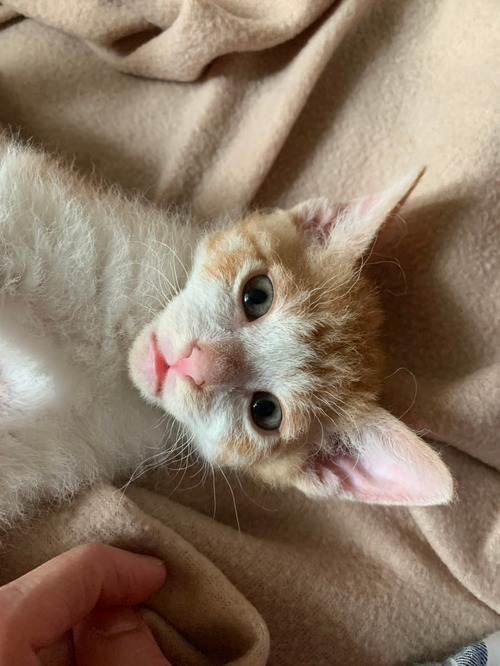